# Importing Libraries

In [75]:
!pip3 install yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# BITCOIN

In [76]:
stocks = 'BTC-USD'
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2023,1,1)
stock_price = yf.download(stocks, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [77]:
stock_price.head()

Date
2019-01-01    3843.520020
2019-01-02    3943.409424
2019-01-03    3836.741211
2019-01-04    3857.717529
2019-01-05    3845.194580
Name: Close, dtype: float64

In [78]:
stock_price.tail()

Date
2022-12-27    16717.173828
2022-12-28    16552.572266
2022-12-29    16642.341797
2022-12-30    16602.585938
2022-12-31    16547.496094
Name: Close, dtype: float64

# Checking for missing values

In [79]:
print(stock_price.isnull().sum())

0


# Analyze the descriptive statistics

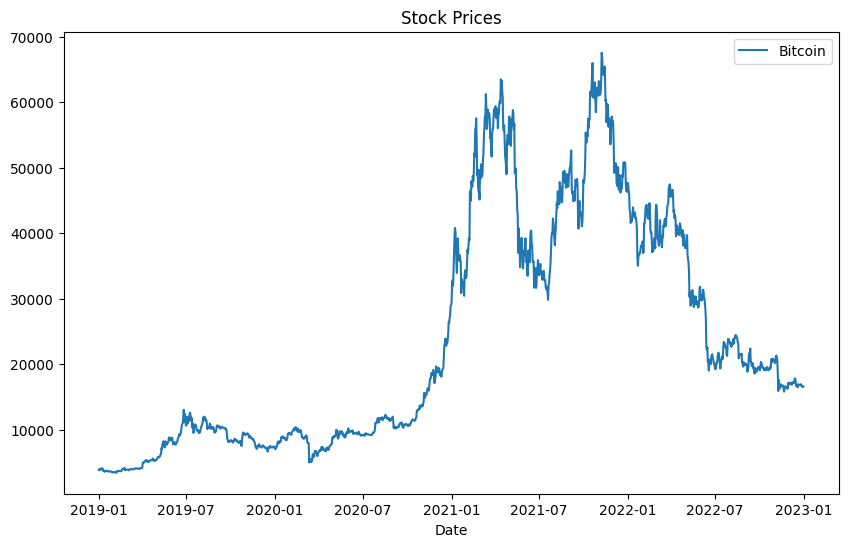

In [81]:
plt.figure(figsize=(10,6))
plt.title('Stock Prices')
plt.xlabel('Date')
plt.plot(stock_price,label='Bitcoin')
plt.legend()

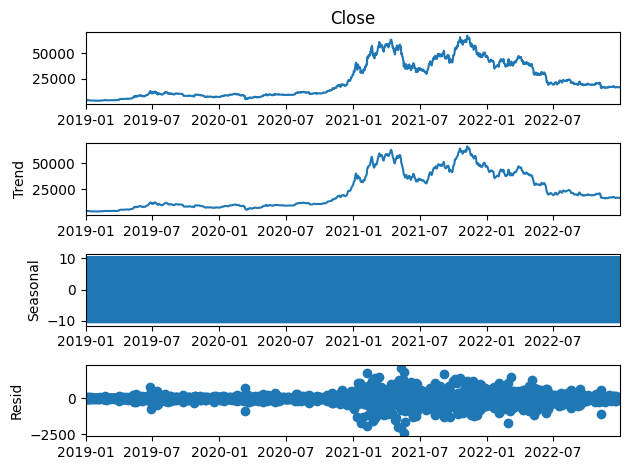

In [82]:
decomposition = seasonal_decompose(stock_price, model='additive', period=2)
decomposition.plot()
plt.show()

# Anamoly Detection
- Anomaly detection is used to alert abnormal behavior because anomalies show something different is happening than expected

In [83]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
stock_scaled = scaler.fit_transform(stock_price.\
values.reshape(-1, 1))
stock_scaled = pd.DataFrame(stock_scaled)

In [85]:
contamination = 0.01
isolation_forest = IsolationForest(contamination=contamination)
isolation_forest.fit(stock_scaled)
stock_scaled['anomaly'] = isolation_forest.predict(stock_scaled)

In [86]:
stock_scaled['anomaly'].value_counts()

 1    1446
-1      15
Name: anomaly, dtype: int64

# What is Stationary??

- It refers to the constant distribution over time depending on the period

# ACF

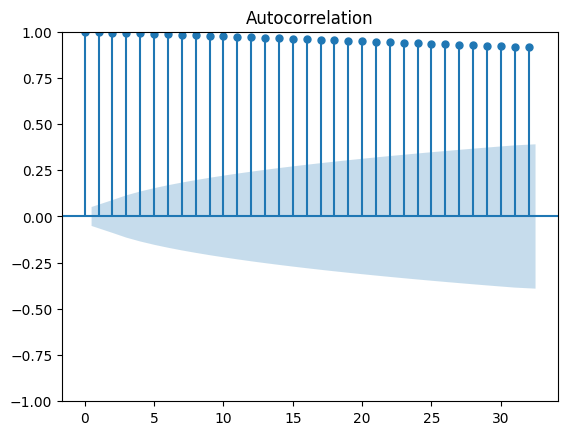

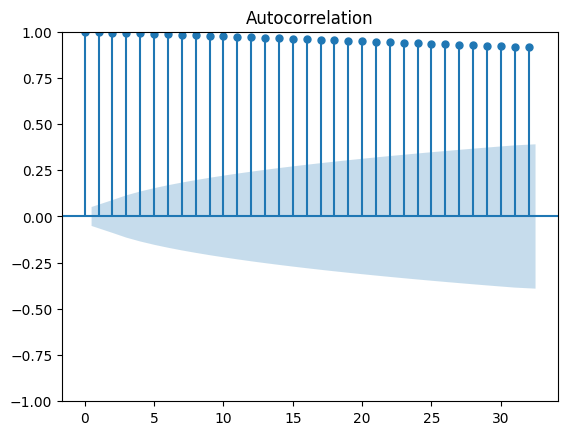

In [87]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(stock_price)

- The acf plot indicates that acf is slowly decaying, which is an indicator of non-stationarity.

Text(0, 0.5, 'Differenced Stock Price')

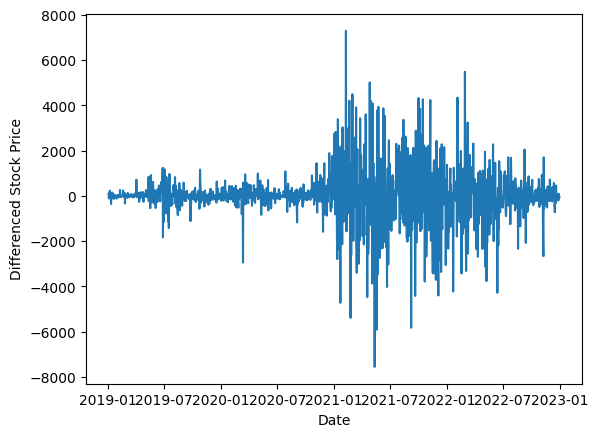

In [88]:
plt.plot(stock_price.diff())
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')

-  First difference help determine whether there is a pattern in a set of data, as well as the nature of the pattern.

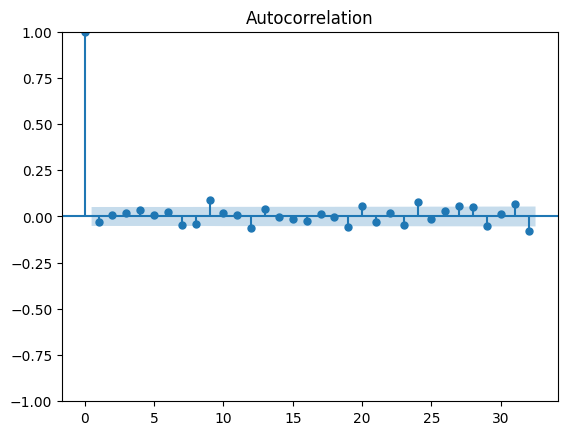

In [89]:
sm.graphics.tsa.plot_acf(stock_price.diff().dropna());

- After taking the first difference we can see all the lags are in the blue region.

# ADF
- Augmented Dickey Fuller test is used to detect the stationary. 

In [90]:
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(stock_price)
print('The test statictics is {} and p-value is {}'.format(stat_test[0], stat_test[1]))

The test statictics is -1.497453331261496 and p-value is 0.5347707612398911


- As p-value is higher than 0.05 which indicates that the time series is non-stationary.

In [91]:
stat_test = adfuller(stock_price.diff().dropna())
print('The test statistic is {} and p-value of ADF test is {}'.format(stat_test[0], 
                                                                      stat_test[1]))

The test statistic is -7.468040680753192 and p-value of ADF test is 5.142021313632695e-11


# PACF

In [92]:
stock_price_diff = stock_price.diff().dropna()

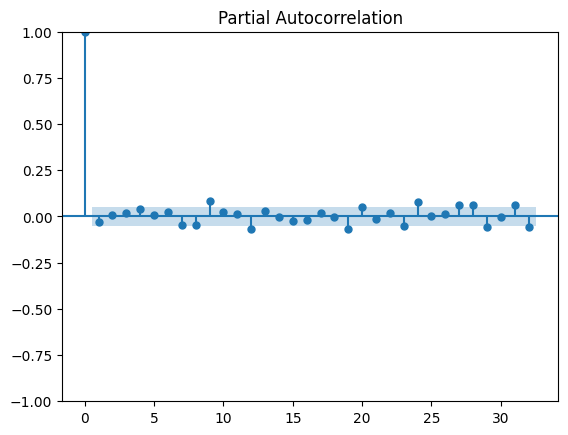

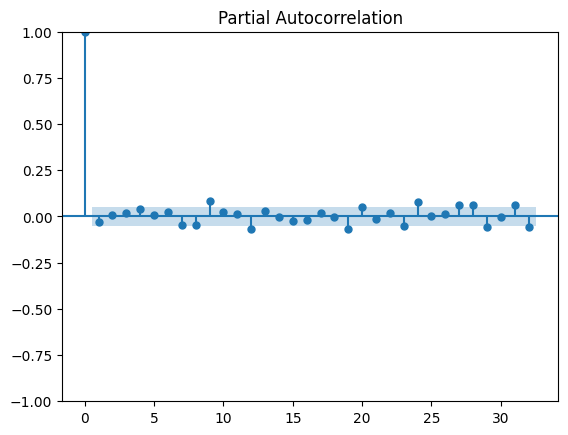

In [93]:
sm.graphics.tsa.plot_pacf(stock_price_diff)

- pacf finds correlations between the residuals that are left after removing the effects that are already explained by the earlier lag(s) with the next lag value, making it "partial" rather than "complete" because we first remove previously discovered variations. 

# Moving Average

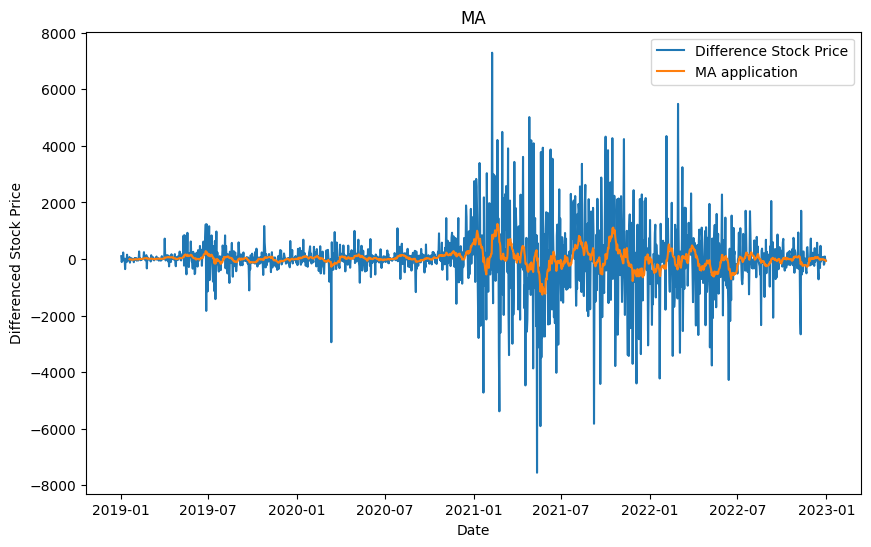

In [94]:
moving_average_blk = stock_price_diff.rolling(window=18).mean()
plt.figure(figsize=(10,6))
plt.plot(stock_price_diff.loc[start:end].index, stock_price_diff.loc[start:end],
         label='Difference Stock Price')
plt.plot(moving_average_blk.loc[start:end].index, moving_average_blk.loc[start:end],
        label='MA application')
plt.title('MA')
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.legend()

# ARIMA

In [95]:
from statsmodels.tsa.arima.model import ARIMA
ma_model = ARIMA(stock_price_diff, order=(0,0,8))
ma_result = ma_model.fit()

In [96]:
train_len = int(len(stock_price_diff) * 0.8)
diff_train = stock_price_diff[:train_len]
diff_test = stock_price_diff[train_len:]

In [97]:
start = len(diff_train) 
end = len(diff_train) + len(diff_test) - 1 

In [98]:
ma_pred = ma_result.predict(start, end)
ma_pred.index = diff_test.index

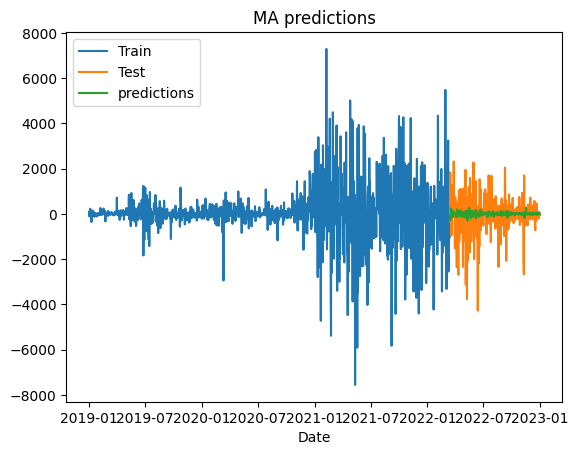

In [99]:
plt.plot(diff_train.index, diff_train, label='Train')
plt.plot(diff_test.index, diff_test, label='Test')
plt.plot(ma_pred.index, ma_pred, label='predictions')
plt.title('MA predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [100]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(diff_test, ma_pred)
mse_naive = mean_squared_error(diff_test, ma_pred)
rmse_naive = np.sqrt(mean_squared_error(diff_test, ma_pred))

In [101]:
naive_perf = {'mae_naive': mae_naive,
             'mse_naive':mse_naive,
             'rmse_naive':rmse_naive}
naive_perf = pd.DataFrame([naive_perf])
naive_perf

,mae_naive,mse_naive,rmse_naive
0,560.238666,722071.679364,849.748009


In [102]:
ma_model = ARIMA(stock_price_diff, order=(0,0,8))
ma_result = ma_model.fit()

In [103]:
forecast_index = pd.date_range(diff_test.index[-1], periods=10)

In [104]:
ma_forecast = ma_result.forecast(steps=10)
ma_forecast.index = forecast_index

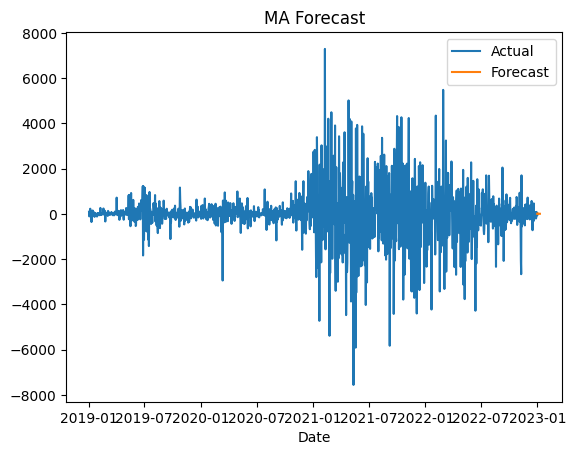

In [105]:
plt.plot(stock_price_diff.index, stock_price_diff, label='Actual')
plt.plot(ma_forecast.index, ma_forecast, label='Forecast')
plt.legend()
plt.title('MA Forecast')
plt.xlabel('Date')
plt.show()

# DOUBLE EXPONENTIAL SMOOTHING

In [106]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
train_len = int(len(stock_price) * 0.8)
train = stock_price[:train_len]
test = stock_price[train_len:]
des_model = Holt(train)
des_result = des_model.fit(smoothing_level=0.3, smoothing_slope=.05)

In [107]:
start_raw = len(train)
end_raw = len(train) + len(test) - 1
des_pred = des_result.predict(start_raw, end_raw)
des_pred.index = test.index

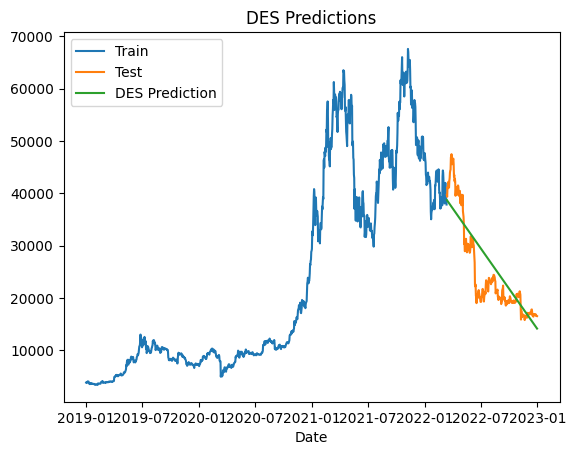

In [108]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(des_pred.index, des_pred, label='DES Prediction')
plt.title('DES Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_des = mean_absolute_error(test, des_pred)
mse_des= mean_squared_error(test, des_pred)
rmse_des = np.sqrt(mean_squared_error(test, des_pred))

In [110]:
des_perf = {'mae_des':mae_des,
'mse_des':mse_des,
'rmse_des':rmse_des}
des_perf = pd.DataFrame([des_perf])
des_perf

,mae_des,mse_des,rmse_des
0,3705.599347,2.115104e+07,4599.025962


In [111]:
diff_train_len = int(len(stock_price_diff) *0.8)
diff_train = stock_price_diff[:diff_train_len]
diff_test = stock_price_diff[diff_train_len:]
forecast_index = pd.date_range(diff_test.index[-1], periods=10)
des = Holt(stock_price).fit()
des_forecast = des.forecast(steps=10)
des_forecast.index = forecast_index

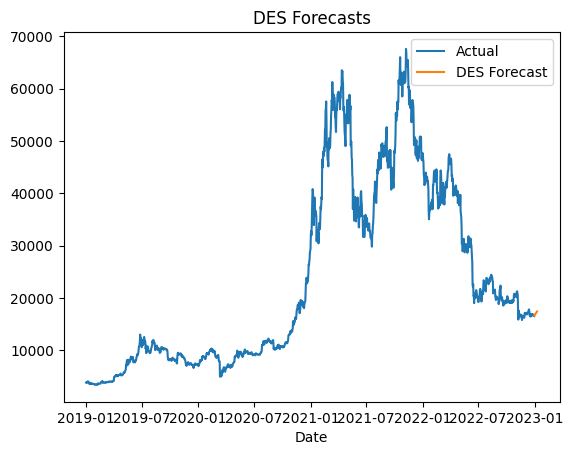

In [112]:
plt.plot(stock_price.index, stock_price, label='Actual')
plt.plot(des_forecast.index, des_forecast, label='DES Forecast')
plt.legend()
plt.xlabel('Date')
plt.title('DES Forecasts')
plt.show()

# ETHEREUM

In [114]:
stocks = 'ETH-USD'
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2023,1,1)
stock = yf.download(stocks, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [115]:
stock.head()

Date
2019-01-01    140.819412
2019-01-02    155.047684
2019-01-03    149.135010
2019-01-04    154.581940
2019-01-05    155.638596
Name: Close, dtype: float64

In [116]:
stock.tail()

Date
2022-12-27    1212.791626
2022-12-28    1189.986084
2022-12-29    1201.595337
2022-12-30    1199.232788
2022-12-31    1196.771240
Name: Close, dtype: float64

# Checking for missing values

In [117]:
print(stock.isnull().sum())

0


# Analyze the descriptive statistics

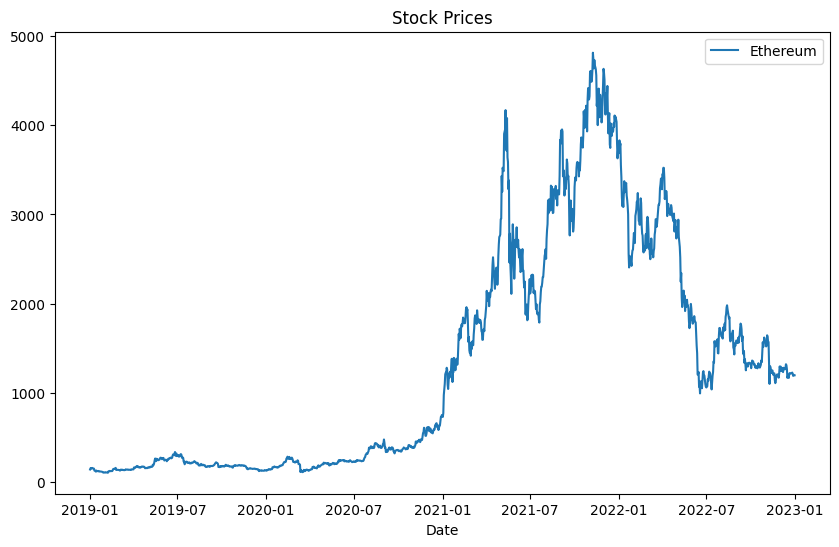

In [118]:
plt.figure(figsize=(10,6))
plt.title('Stock Prices')
plt.xlabel('Date')
plt.plot(stock,label='Ethereum')
plt.legend()

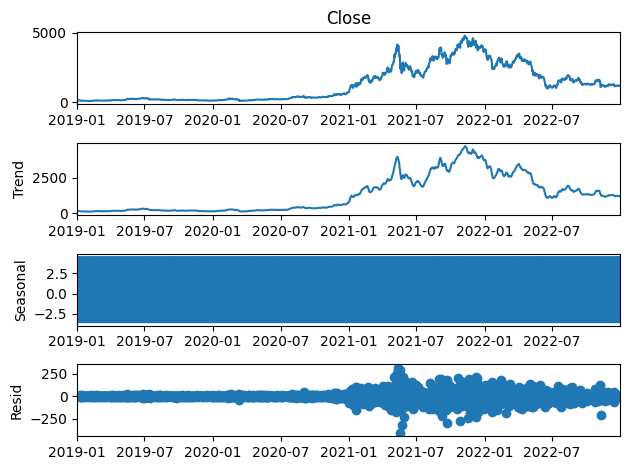

In [119]:
decompose = seasonal_decompose(stock, model='additive', period=5)
decompose.plot()
plt.show()

# Anamoly Detection

In [120]:
scaler = StandardScaler()
stock_scaled = scaler.fit_transform(stock.\
values.reshape(-1, 1))
stock_scaled = pd.DataFrame(stock_scaled)

In [121]:
contamination = 0.01
isolation_forest = IsolationForest(contamination=contamination)
isolation_forest.fit(stock_scaled)
stock_scaled['anomaly'] = isolation_forest.predict(stock_scaled)

In [122]:
stock_scaled['anomaly'].value_counts()

 1    1446
-1      15
Name: anomaly, dtype: int64

# ACF

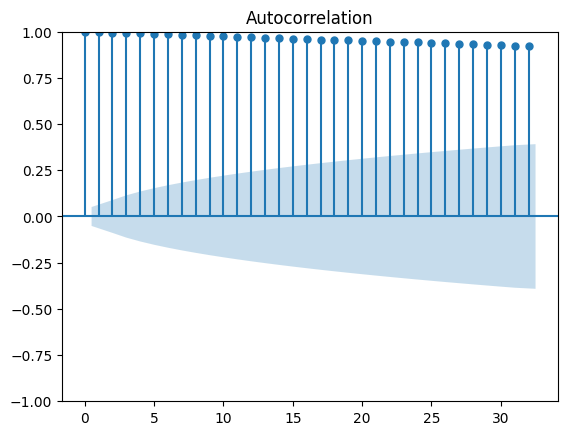

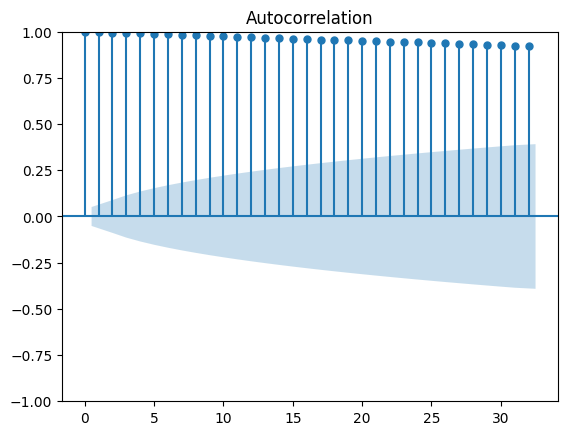

In [123]:
sm.graphics.tsa.plot_acf(stock)

Text(0, 0.5, 'Differenced Stock Price')

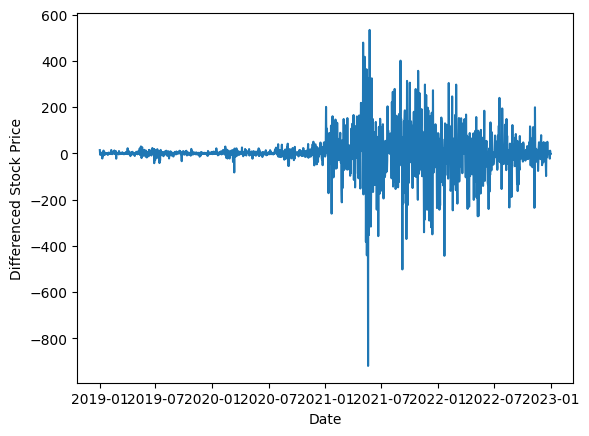

In [124]:
plt.plot(stock.diff()) 
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')

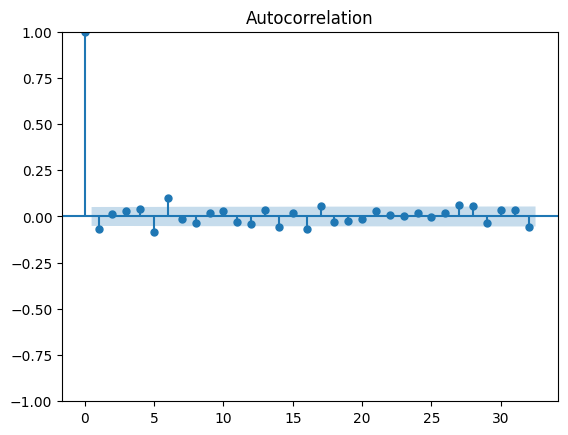

In [125]:
sm.graphics.tsa.plot_acf(stock.diff().dropna());

# ADF

In [126]:
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(stock)
print('The test statistic is {} and p-value of ADF test is {}'.format(stat_test[0], 
                                                                      stat_test[1]))

The test statistic is -1.389635095013947 and p-value of ADF test is 0.5872349735947687


In [127]:
stat_test = adfuller(stock.diff().dropna())
print('The test statistic is {} and p-value of ADF test is {}'.format(stat_test[0], 
                                                                      stat_test[1]))

The test statistic is -9.601879988840446 and p-value of ADF test is 1.9109311638500235e-16


# PACF

In [128]:
stock_diff = stock.diff().dropna()

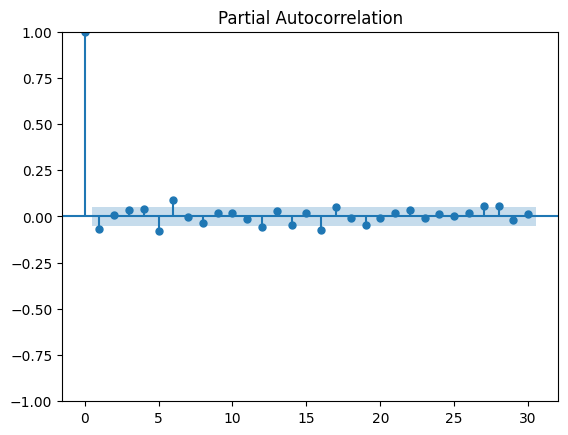

In [129]:
sm.graphics.tsa.plot_pacf(stock_diff, lags=30)
plt.show()

# Moving Average

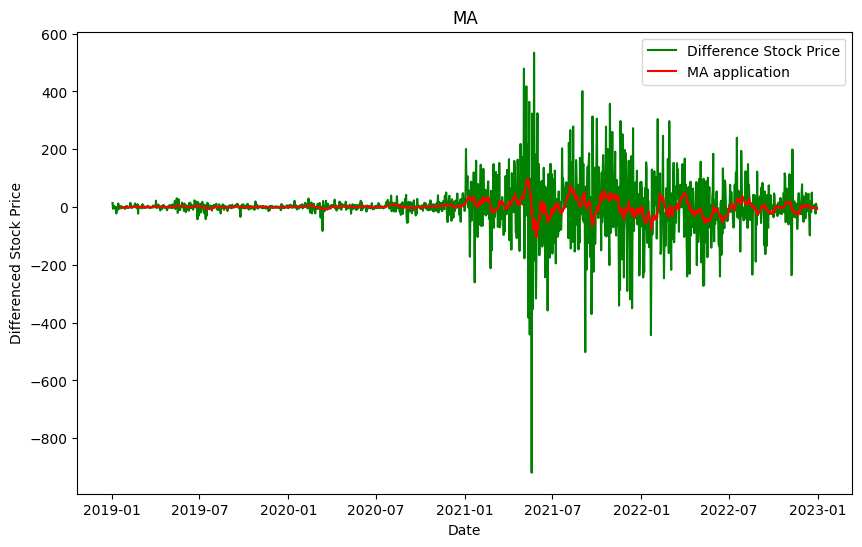

In [130]:
moving_average_blk = stock_diff.rolling(window=18).mean()
plt.figure(figsize=(10,6))
plt.plot(stock_diff.loc[start:end].index, stock_diff.loc[start:end],
         label='Difference Stock Price', c='g')
plt.plot(moving_average_blk.loc[start:end].index, moving_average_blk.loc[start:end],
        label='MA application', c='r')
plt.title('MA')
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.legend()
plt.show()

# ARIMA

In [131]:
from statsmodels.tsa.arima.model import ARIMA
ma_model = ARIMA(stock_diff, order=(0,0,8))
ma_result = ma_model.fit()

In [132]:
train_len = int(len(stock_diff) * 0.8)
diff_train = stock_diff[:train_len]
diff_test = stock_diff[train_len:]

In [133]:
start = len(diff_train) 
end = len(diff_train) + len(diff_test) - 1 

In [134]:
ma_pred = ma_result.predict(start, end)
ma_pred.index = diff_test.index

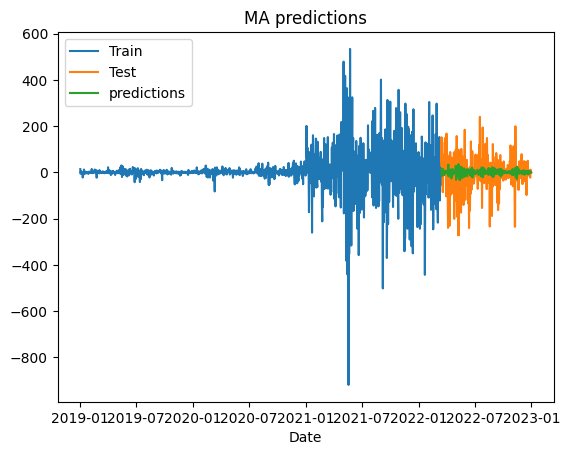

In [135]:
plt.plot(diff_train.index, diff_train, label='Train')
plt.plot(diff_test.index, diff_test, label='Test')
plt.plot(ma_pred.index, ma_pred, label='predictions')
plt.title('MA predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(diff_test, ma_pred)
mse_naive = mean_squared_error(diff_test, ma_pred)
rmse_naive = np.sqrt(mean_squared_error(diff_test, ma_pred))

In [137]:
naive_perf = {'mae_naive': mae_naive,
             'mse_naive':mse_naive,
             'rmse_naive':rmse_naive}
naive_perf = pd.DataFrame([naive_perf])
naive_perf

,mae_naive,mse_naive,rmse_naive
0,55.280641,6043.980875,77.743044


In [138]:
ma_model = ARIMA(stock_price_diff, order=(0,0,8))
ma_result = ma_model.fit()

In [148]:
forecast_index = pd.date_range(diff_test.index[-1], periods=10)
ma_forecast = ma_result.forecast(steps=10)
ma_forecast.index = forecast_index

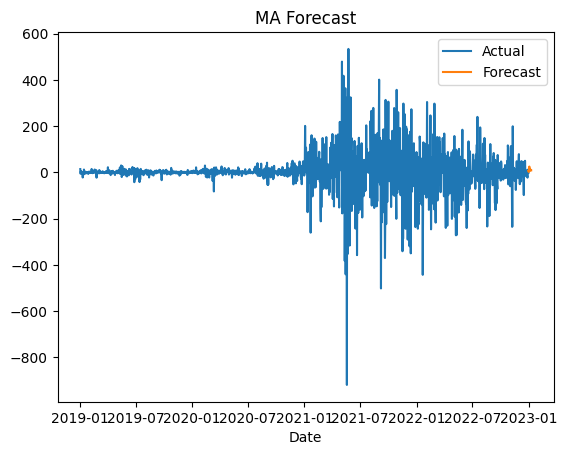

In [149]:
plt.plot(stock_diff.index, stock_diff, label='Actual')
plt.plot(ma_forecast.index, ma_forecast, label='Forecast')
plt.legend()
plt.title('MA Forecast')
plt.xlabel('Date')
plt.show()

# DOUBLE EXPONENTIAL SMOOTHING

In [150]:
train_len = int(len(stock) * 0.8)
train = stock[:train_len]
test = stock[train_len:]
des_model = Holt(train)
des_result = des_model.fit(smoothing_level=0.3, smoothing_slope=.05)

In [151]:
start_raw = len(train)
end_raw = len(train) + len(test) - 1
des_pred = des_result.predict(start_raw, end_raw)
des_pred.index = test.index

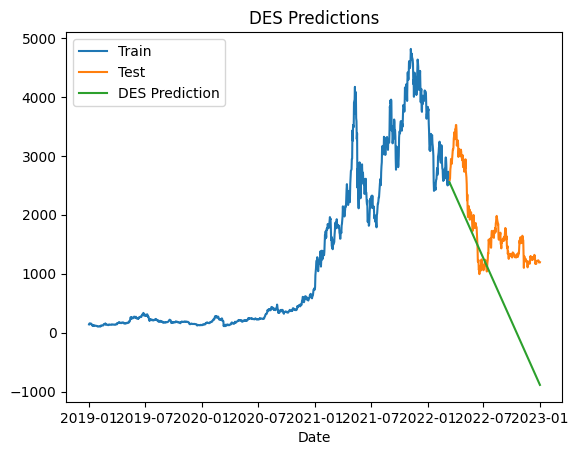

In [152]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(des_pred.index, des_pred, label='DES Prediction')
plt.title('DES Predictions')
plt.legend()
plt.xlabel('Date')
plt.show()

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_des = mean_absolute_error(test, des_pred)
mse_des= mean_squared_error(test, des_pred)
rmse_des = np.sqrt(mean_squared_error(test, des_pred))

In [154]:
des_perf = {'mae_des':mae_des,
'mse_des':mse_des,
'rmse_des':rmse_des}
des_perf = pd.DataFrame([des_perf])
des_perf

,mae_des,mse_des,rmse_des
0,966.840269,1.279844e+06,1131.30188


In [155]:
diff_train_len = int(len(stock_diff) *0.8)
diff_train = stock_diff[:diff_train_len]
diff_test = stock_diff[diff_train_len:]
forecast_index = pd.date_range(diff_test.index[-1], periods=10)
des = Holt(stock).fit()
des_forecast = des.forecast(steps=10)
des_forecast.index = forecast_index

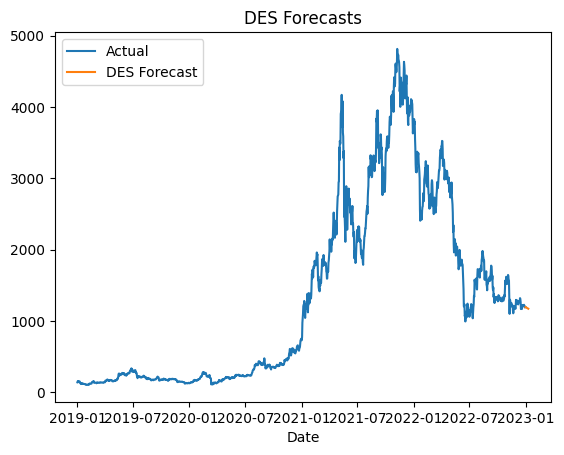

In [156]:
plt.plot(stock.index, stock, label='Actual')
plt.plot(des_forecast.index, des_forecast, label='DES Forecast')
plt.legend()
plt.xlabel('Date')
plt.title('DES Forecasts')
plt.show()

# <center> LSTM

In [1]:
# !pip install yfinance

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Importing required libraries

In [3]:
import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# BITCOIN

### Load the data

In [4]:
stocks = 'BTC-USD'
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2023,1,1)
stock_price = yf.download(stocks, start=start, end=end, interval='1d')['Close']


[*********************100%***********************]  1 of 1 completed


### Convert data to numpy array

In [5]:
data = np.array(stock_price).reshape(-1, 1)

### Scale the data using MinMaxScaler

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

### Split the data into training and testing sets

In [7]:
train_data = scaled_data[:int(0.8 * len(scaled_data))]
test_data = scaled_data[int(0.8 * len(scaled_data)):]

### Create sequences of length 10


In [8]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


### Convert numpy arrays to PyTorch tensors

In [9]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

## LSTM Model

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


### Training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40
loss_list = []
for epoch in range(num_epochs):
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/40], Loss: 0.6105
Epoch [11/40], Loss: 0.4275
Epoch [21/40], Loss: 0.2220
Epoch [31/40], Loss: 0.1407


### Evaluation

In [12]:
# Set model to evaluation mode
model.eval()

# Make predictions on test data
y_pred = model(X_test.to(device)).detach().cpu().numpy()

# Inverse scale the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', rmse)


RMSE: 3777.055789152634


### Evaluation Plot

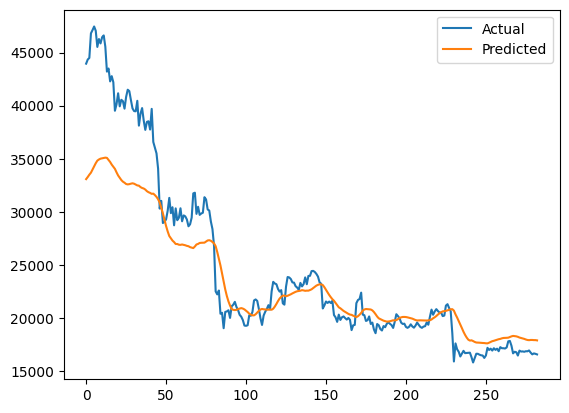

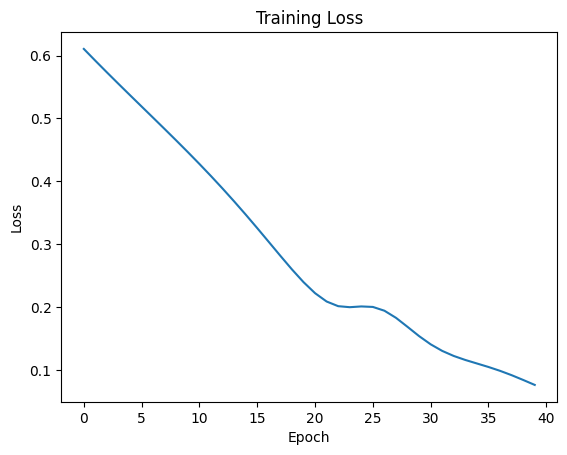

In [13]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Plot loss over training epochs
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# ETHEREUM

### Load the data

In [14]:
stocks = 'ETH-USD'
start = datetime.datetime(2019,1,1)
end = datetime.datetime(2023,1,1)
stock = yf.download(stocks, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


### Convert data to numpy array

In [15]:
data = np.array(stock_price).reshape(-1, 1)

### Scale the data using MinMaxScaler

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)


### Split the data into training and testing sets

In [17]:
train_data = scaled_data[:int(0.8 * len(scaled_data))]
test_data = scaled_data[int(0.8 * len(scaled_data)):]

### Create sequences of length 10

In [18]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

### Convert numpy arrays to PyTorch tensors

In [19]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

## LSTM Model

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


### Training the Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
loss_list = []
for epoch in range(num_epochs):
    outputs = model(X_train.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.to(device))
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/100], Loss: 0.5027
Epoch [11/100], Loss: 0.3686
Epoch [21/100], Loss: 0.2078
Epoch [31/100], Loss: 0.1189
Epoch [41/100], Loss: 0.0435
Epoch [51/100], Loss: 0.0132
Epoch [61/100], Loss: 0.0135
Epoch [71/100], Loss: 0.0080
Epoch [81/100], Loss: 0.0065
Epoch [91/100], Loss: 0.0052


### Evaluation

In [22]:
# Set model to evaluation mode
model.eval()

# Make predictions on test data
y_pred = model(X_test.to(device)).detach().cpu().numpy()

# Inverse scale the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', rmse)


RMSE: 2035.1805744707212


### Evaluation Plot

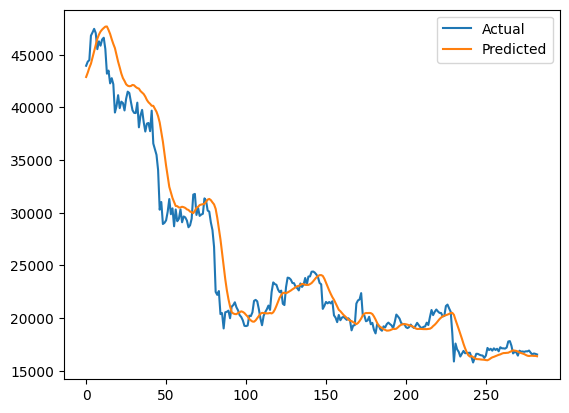

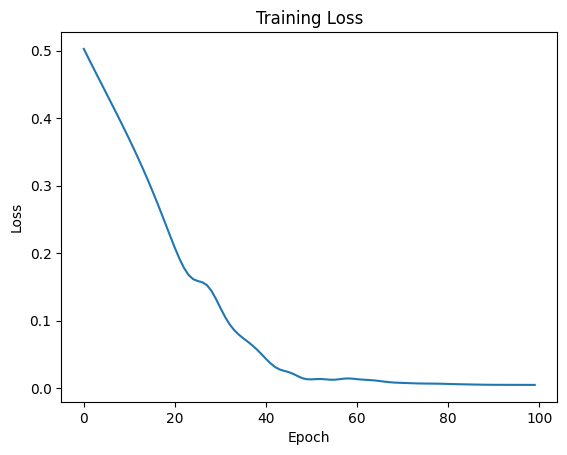

In [23]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# Plot loss over training epochs
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### Conclusion:
We can see that in the graph that the loss in the LSTM model decreases as we increase the epoch.<br>
We have trained it for both Bitcoin and Etherium but the model suits better for the Etherium, this may be because Etherium is more stable in the market than Bitcoin.